<a href="https://colab.research.google.com/github/Shemonti/Breast-Histology-Images/blob/main/IDC_Image_classification_with_EANet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import fnmatch
import os
import PIL
import glob
import tensorflow as tf
from matplotlib.image import  imread
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import seaborn as sns
import warnings
warnings.filterwarnings(action = 'ignore')
import matplotlib.pyplot as plt

from PIL import Image

In [ ]:
!unrar x -Y "/content/drive/MyDrive/data_used (1).rar" 

Streaming output truncated to the last 5000 lines.
Extracting  data_used/IDC/12906_idx5_x1701_y1701_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1751_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1801_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1851_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1901_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1951_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y2001_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y2151_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y2201_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y2251_class1.png               35%  OK 
Extracting  data_used/IDC/129

In [ ]:
import pathlib
dt_dir='/content/data_used'
data_dir = pathlib.Path(dt_dir)
data_dir

PosixPath('/content/data_used')

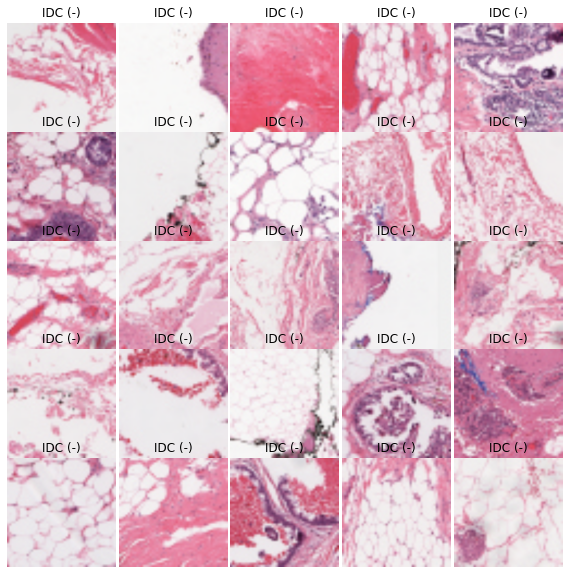

In [ ]:
NORMAL=list(data_dir.glob('NORMAL/*.png'))
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for imgname in NORMAL[:25]:
    im = cv2.imread(str(imgname))
    im = cv2.resize(im, (227, 227)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.axis('off')        
    plt.title('IDC (-)')
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB));
     #.set_title(l)
     
    i_ += 1

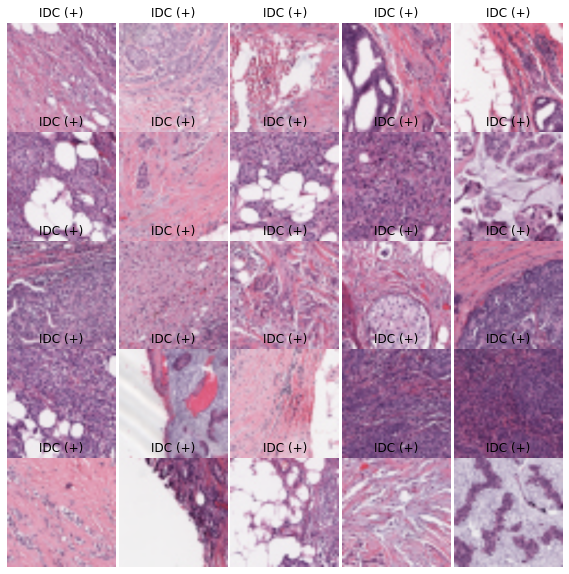

In [ ]:
IDC=list(data_dir.glob('IDC/*.png'))
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for imgname in IDC[:25]:
   



    im = cv2.imread(str(imgname))
    im = cv2.resize(im, (227, 227)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.axis('off')        
    plt.title('IDC (+)')
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB));
     #.set_title(l)
     
    i_ += 1

In [ ]:
breast_images_dict = {
    'IDC(-)': list(data_dir.glob('NORMAL/*.png')),
    'IDC(+)': list(data_dir.glob('IDC/*.png')),
    
}

In [ ]:
breast_labels_dict = {
    'IDC(-)': 0,
    'IDC(+)': 1
   
}

In [ ]:
X, y = [], []

for breast_name, images in breast_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        im = cv2.resize(img, (64, 64))
        X.append(im)
        y.append(breast_labels_dict[breast_name])

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
im.shape

(64, 64, 3)

In [ ]:
X.shape

(7500, 64, 64, 3)

In [ ]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
len(y)

7500

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.3, random_state=42)
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_val = to_categorical(y_val)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(5250, 64, 64, 3) (675, 64, 64, 3) (1575, 64, 64, 3) (5250,) (675,) (1575,)


In [ ]:
y_val

array([1, 0, 1, ..., 0, 1, 0])

In [ ]:
len(X_train)

5250

In [ ]:
len(X_test)

675

In [ ]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255
X_val_scaled = X_val / 255

In [ ]:
data_augmentation = keras.Sequential(
  [
   layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(64, 
                                                              64,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

EANet

In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.6 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [ ]:
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
# validation_split = 0.2
batch_size = 128
num_epochs = 50
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (im.shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 1024


In [ ]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

In [ ]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [ ]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

In [ ]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

In [ ]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=im.shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(2, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = get_model(attention_type="external_attention")
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# model.compile(
#     loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
#     optimizer=tfa.optimizers.AdamW(
#         learning_rate=learning_rate, weight_decay=weight_decay
#     ),
#     metrics=[
#         keras.metrics.CategoricalAccuracy(name="accuracy"),
#         keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
#     ],
# )

# history = model.fit(
#     x_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=num_epochs,
#     validation_split=validation_split,
# )
history=model.fit(X_train_scaled, y_train, epochs=num_epochs,validation_data = (X_val_scaled,y_val))

Epoch 1/50
165/165 [==============================] - 58s 277ms/step - loss: 0.5008 - accuracy: 0.7813 - val_loss: 0.3025 - val_accuracy: 0.8978
Epoch 2/50
165/165 [==============================] - 44s 268ms/step - loss: 0.3104 - accuracy: 0.8710 - val_loss: 0.5911 - val_accuracy: 0.8317
Epoch 3/50
165/165 [==============================] - 44s 266ms/step - loss: 0.3017 - accuracy: 0.8752 - val_loss: 0.2669 - val_accuracy: 0.8959
Epoch 4/50
165/165 [==============================] - 45s 270ms/step - loss: 0.2853 - accuracy: 0.8781 - val_loss: 0.2466 - val_accuracy: 0.9073
Epoch 5/50
165/165 [==============================] - 44s 269ms/step - loss: 0.2643 - accuracy: 0.8878 - val_loss: 0.2643 - val_accuracy: 0.9035
Epoch 6/50
165/165 [==============================] - 44s 269ms/step - loss: 0.2473 - accuracy: 0.8987 - val_loss: 0.2045 - val_accuracy: 0.9124
Epoch 7/50
165/165 [==============================] - 44s 269ms/step - loss: 0.2381 - accuracy: 0.9000 - val_loss: 0.2121 - val_ac

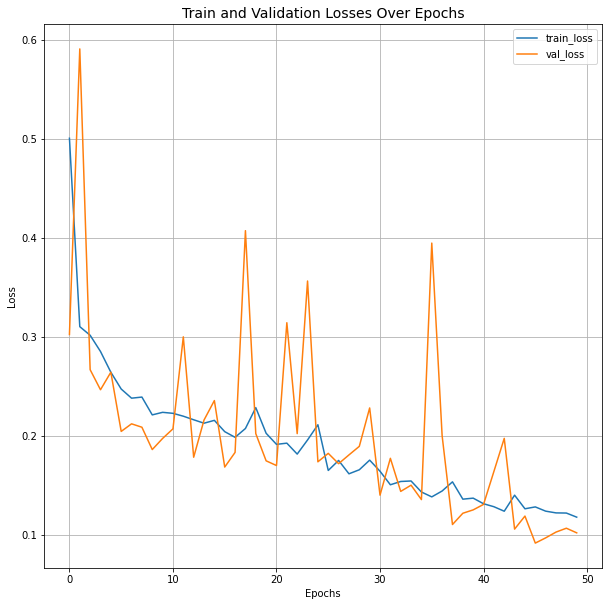

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.evaluate(X_test_scaled,y_test)

22/22 [==============================] - 2s 89ms/step - loss: 0.0763 - accuracy: 0.9674


[0.07629543542861938, 0.9674074053764343]

In [ ]:
predictions = model.predict(X_test_scaled)
predictions[:5]

22/22 [==============================] - 4s 88ms/step


array([[9.8108554e-01, 1.8914424e-02],
       [9.9996960e-01, 3.0374016e-05],
       [2.7597836e-05, 9.9997234e-01],
       [7.9466344e-04, 9.9920541e-01],
       [5.5541582e-03, 9.9444580e-01]], dtype=float32)

In [ ]:
y_pred = [np.argmax(element) for element in predictions]
y_pred[:5]

[0, 0, 1, 1, 1]

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       416
           1       0.95      0.97      0.96       259

    accuracy                           0.97       675
   macro avg       0.96      0.97      0.97       675
weighted avg       0.97      0.97      0.97       675



In [ ]:
confusion=(confusion_matrix(y_test,y_pred))

Text(87.0, 0.5, 'Truth')

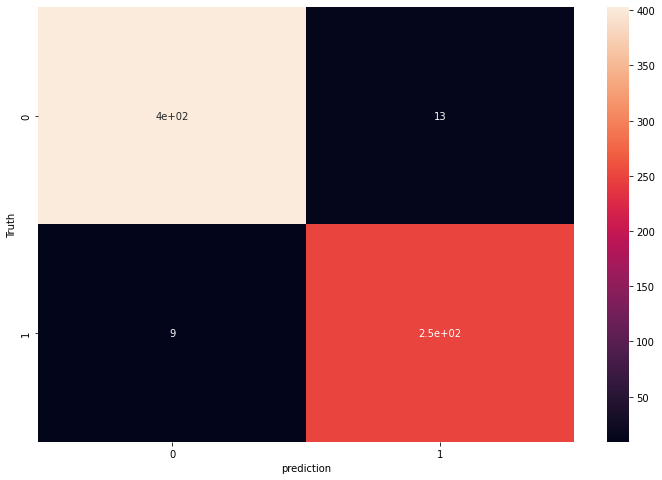

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion,annot=True)
plt.xlabel('prediction')
plt.ylabel('Truth')#depthwiseunit_depthwise_kernel=5

In [ ]:
from sklearn import metrics

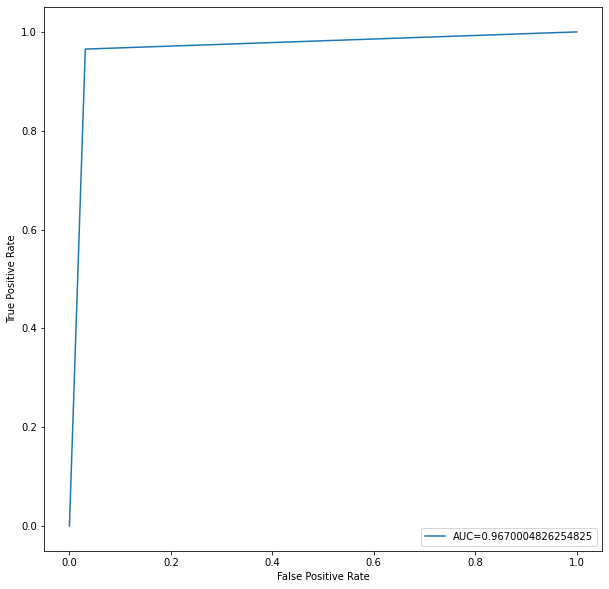

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

CONVXNET

In [ ]:
# import numpy as np # linear algebra
# import pandas as pd
# from tqdm import tqdm
# from glob import glob
# from keras.layers import *
# from keras.models import *
# from keras.utils import *
# import numpy as np
# import os
# from tensorflow.keras.optimizers import Adam

In [ ]:
# def Residual_Unit(input_tensor, nb_of_input_channels, max_dilation, number_of_units):
#   for i in range(number_of_units):
#     x1 = Conv2D(nb_of_input_channels*2, kernel_size = (5,5), strides = (1,1), padding='same', dilation_rate= (1,1),activation='relu' )(input_tensor)
#     x1 = BatchNormalization()(x1)
  
#     a = []

#     for i in range(1, max_dilation+1):
#       temp = DepthwiseConv2D( kernel_size=(5,5), dilation_rate = (i,i), padding = 'same',)(x1)
#       temp = BatchNormalization()(temp)
#       a.append(temp)

#     x = Concatenate(axis= -1)(a)
#     x = Conv2D(nb_of_input_channels, kernel_size = (5,5), strides = (1,1), padding='same', dilation_rate= (1,1),)(x)
#     x = BatchNormalization()(x)

#     x = Add()([x, input_tensor])

#     input_tensor = x
  
#   return x

In [ ]:
# def Shifter_Unit(input_tensor, nb_of_input_channels, max_dilation):
#     x1 = Conv2D(nb_of_input_channels*4, kernel_size = (5,5), strides = (1,1), padding='same', dilation_rate= (1,1),activation='relu')(input_tensor)
#     x1 = BatchNormalization()(x1)

#     a = []

#     for i in range(1, max_dilation+1):
#       temp = DepthwiseConv2D( kernel_size=(5,5), dilation_rate = (i,i), padding = 'same',)(x1)
#       temp = MaxPool2D(pool_size=(2,2))(temp)
#       temp = BatchNormalization()(temp)
#       a.append(temp)

#     x = Concatenate(axis= -1)(a)

#     x = Conv2D(nb_of_input_channels*2, kernel_size = (5,5), strides = (1,1), padding='same', dilation_rate= (1,1),)(x)
#     x = BatchNormalization()(x)

#     return x

In [ ]:
# def Network64(input_shape, nb_class, depth):
#   xin = Input(shape= input_shape)

#   x = Conv2D(16, kernel_size = (3,3), strides= (1,1), padding = 'same', activation='relu')(xin)
#   x = BatchNormalization()(x)

#   x = Conv2D(32, kernel_size = (3,3), strides= (2,2), padding = 'same',activation='relu' )(x)
#   x = BatchNormalization()(x)
  
# ##Max Dilation rate will be vary in the range (1,4). 

# # Max Dilation rate is 4 for tensor (32x32x32)
#   x = Residual_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=4, number_of_units=depth)
#   x = Shifter_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=4)


# # Max Dilation rate is 3 for (16x16x64)
#   x = Residual_Unit(input_tensor=x, nb_of_input_channels=64, max_dilation=3, number_of_units=depth)
#   x = Shifter_Unit(input_tensor=x, nb_of_input_channels=64, max_dilation=3)

# # Max Dilation rate is 2 for (8x8x128)
#   x = Residual_Unit(input_tensor=x, nb_of_input_channels=128, max_dilation=2, number_of_units=depth)
#   x = Conv2D(128, kernel_size = (5,5), strides= (2,2), padding = 'same', activation='relu')(x)
#   x = Conv2D(64, kernel_size = (5,5), strides= (2,2), padding = 'same', activation='relu')(x)
#   x = GlobalMaxPooling2D()(x)

#   x = Dense(64, activation='relu')(x)
#   x = Dense(nb_class, activation= 'softmax')(x)

#   model = Model(xin, x)
#   # model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = 1e-3), metrics = ['accuracy'])
#   model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
              
#   return model

In [ ]:
# model = Network64(input_shape = (64, 64, 3), nb_class = 2, depth = 5)
# model.summary()

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from keras.layers import Input, Dense, Activation, Dropout
# from keras.models import Model
# from tensorflow.keras.optimizers import Adam,SGD,Nadam,RMSprop
# from tensorflow.keras.models import load_model

In [ ]:
# ''' Callbacks with Checkpoint'''



# accuracy_threshold = 0.98

# class myCallback(keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#       if(logs.get('accuracy')>accuracy_threshold):
#         print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
#         self.model.stop_training = True

# acc_callback = myCallback()
#   # Saved the Best Model
# filepath = "/content/drive/MyDrive/best_moel/mymodel_dilateddepth2.h5"
# checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, 
#                                              save_weights_only=False, mode='min')
#   # callback list
# callback_list = [acc_callback, checkpoint]

In [ ]:
# history=model.fit(X_train_scaled, y_train, epochs=50,validation_data = (X_val_scaled,y_val),callbacks=[callback_list],batch_size=7)#modify_depthwisecnn

In [ ]:
# model = load_model("/content/drive/MyDrive/best_moel/mymodel_dilateddepth2.h5")

In [ ]:
# model.evaluate(X_test_scaled,y_test)

In [ ]:
# #-----------------------------------------------------------
# # Retrieve a list of list results on training and test data
# # sets for each training epoch
# #-----------------------------------------------------------
# acc      = history.history['accuracy' ]
# val_acc  = history.history[ 'val_accuracy' ]
# loss     = history.history[    'loss' ]
# val_loss = history.history['val_loss' ]

# epochs   = range(len(acc)) # Get number of epochs

# #------------------------------------------------
# # Plot training and validation accuracy per epoch
# #------------------------------------------------
# plt.plot  ( epochs,     acc )
# plt.plot  ( epochs, val_acc )

# plt.title ('Training and validation accuracy')
# plt.legend(['train', 'val'])
# plt.figure()

# #------------------------------------------------
# # Plot training and validation loss per epoch
# #------------------------------------------------
# plt.plot  ( epochs,     loss )
# plt.plot  ( epochs, val_loss )
# plt.title ('Training and validation loss'   )
# plt.legend(['train', 'val'])

In [ ]:
# model_loss = pd.DataFrame(history.history)
# model_loss.plot()

In [ ]:
# predictions = model.predict(X_test_scaled)
# predictions[:5]

In [ ]:
# y_pred = [np.argmax(element) for element in predictions]
# y_pred[:5]

In [ ]:
# y_test[:5]

In [ ]:
# from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
# print(classification_report(y_test,y_pred))#depthwiseunit_depthwise_kernel=5

In [ ]:
# confusion=(confusion_matrix(y_test,y_pred))

In [ ]:
# plt.figure(figsize=(12,8))
# sns.heatmap(confusion,annot=True)
# plt.xlabel('prediction')
# plt.ylabel('Truth')#depthwiseunit_depthwise_kernel=5

In [ ]:
# from sklearn import metrics

In [ ]:
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
# auc = metrics.roc_auc_score(y_test, y_pred)

# #create ROC curve
# plt.plot(fpr,tpr,label="AUC="+str(auc))
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc=4)
# plt.show()